# Melanoma Detection using Transfer Learning with MobileNetV2

## Introduction
Transfer learning has become a powerful approach in computer vision, especially for medical imaging tasks where annotated datasets are often limited. Instead of training models from scratch, pretrained convolutional neural networks (CNNs) can be fine-tuned to leverage knowledge gained from large-scale datasets like ImageNet. This strategy enables faster convergence, reduces computational costs, and often yields higher accuracy in specialized domains such as disease classification.

In this project, transfer learning is applied using the MobileNetV2 architecture to the task of melanoma detection, where early and reliable diagnosis is crucial for improving patient outcomes.

## Data

The dataset used in this project is sourced from [Kaggle’s Melanoma Cancer Dataset](https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset/data). It contains **13,900 high-quality dermoscopic images**, uniformly resized to **224×224 pixels**, representing both benign and malignant skin lesions.  

The dataset was curated to support research in dermatology and computer-aided diagnostics, with the goal of enabling the development of machine learning models that can distinguish between healthy and cancerous tissue. Its diversity of lesion appearances provides a realistic challenge for classification tasks, making it a suitable benchmark for evaluating the effectiveness of transfer learning approaches in medical image analysis.  


### Data loader
Load data from https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset/data

**for binary task, where** 

* 0 → 'Benign'

* 1 → 'Malignant'

Melanoma is class 1 (Malignant)


**Folder structure (I put everything in 'data' folder):**

data/

├── train/

    ├── Benign/

    └── Malignant/

└── test/

    ├── Benign/
 
    └── Malignant/





In [60]:
# libraries
import tensorflow as tf
import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [62]:
def load_dataset_simple_streamed(base_dir, img_size=(224, 224), batch_size=16):
    class_names = ['Benign', 'Malignant']
    label_map = {name: idx for idx, name in enumerate(class_names)}

    all_image_paths = []
    all_labels = []

    # Combine all images from train/ and test/ folders
    for subset in ['train', 'test']:
        for class_name in class_names:
            folder = os.path.join(base_dir, subset, class_name)
            label = label_map[class_name]

            for fname in os.listdir(folder):
                if fname.endswith('.jpg'):
                    all_image_paths.append(os.path.join(folder, fname))
                    all_labels.append(label)

    # Shuffle together
    combined = list(zip(all_image_paths, all_labels))
    random.seed(42)
    random.shuffle(combined)
    all_image_paths, all_labels = zip(*combined)

    # Create tf.data.Dataset from paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices(list(all_image_paths))
    label_ds = tf.data.Dataset.from_tensor_slices(list(all_labels))

    def load_and_preprocess(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = tf.cast(image, tf.float32) / 255.0  # normalization
        return image, label

    full_ds = tf.data.Dataset.zip((path_ds, label_ds))
    full_ds = full_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # Split into 70/15/15
    total = len(all_image_paths)
    train_size = int(0.7 * total)
    val_size = int(0.15 * total)

    train_ds = full_ds.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = full_ds.skip(train_size).take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = full_ds.skip(train_size + val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

In [27]:
train_ds, val_ds, test_ds, class_names = load_dataset_simple_streamed("data")

In [29]:
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape, labels.shape)

for images, labels in val_ds.take(1):
    print("Val batch shape:", images.shape, labels.shape)

for images, labels in test_ds.take(1):
    print("Test batch shape:", images.shape, labels.shape)

Train batch shape: (16, 224, 224, 3) (16,)
Val batch shape: (16, 224, 224, 3) (16,)
Test batch shape: (16, 224, 224, 3) (16,)


In [31]:
def count_samples(ds):
    return sum(1 for _ in ds.unbatch())

print("Dataset sizes:")
print("Train size:", count_samples(train_ds))
print("Val size:  ", count_samples(val_ds))
print("Test size: ", count_samples(test_ds))

Dataset sizes:
Train size: 9715
Val size:   2081
Test size:  2083


In [34]:
import matplotlib.pyplot as plt

def plot_images_from_ds(ds, class_names=None, n=10):
    plt.figure(figsize=(15, 3))
    for i, (image, label) in enumerate(ds.unbatch().take(n)):
        plt.subplot(1, n, i + 1)
        plt.imshow(image.numpy())
        label_val = label.numpy()
        plt.title(class_names[label_val] if class_names else str(label_val), fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

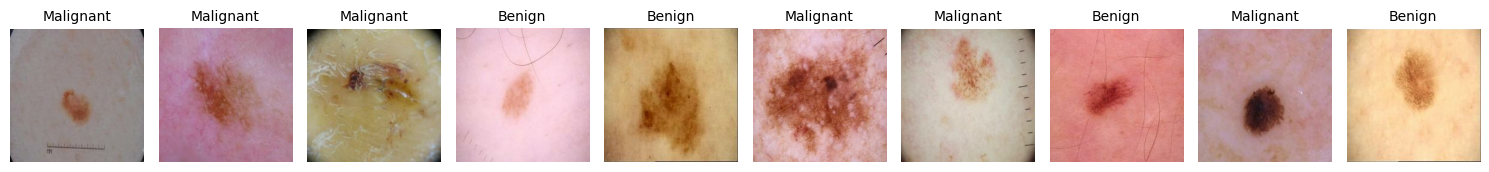

In [47]:
plot_images_from_ds(train_ds, class_names)

In [49]:
# Check image size and dataset size
from PIL import Image
import os

for phase in ['train', 'test']:
    for label in ['Benign', 'Malignant']:
        path = f"./data/{phase}/{label}"
        sample_image = os.listdir(path)[0]
        with Image.open(os.path.join(path, sample_image)) as img:
            print(f"{phase}/{label} - Sample image size: {img.size}, Total images: {len(os.listdir(path))}")

train/Benign - Sample image size: (224, 224), Total images: 6289
train/Malignant - Sample image size: (224, 224), Total images: 5590
test/Benign - Sample image size: (224, 224), Total images: 1000
test/Malignant - Sample image size: (224, 224), Total images: 1000


In [53]:
import numpy as np

def check_class_distribution_ds(train_ds, val_ds, test_ds, class_names):
    def get_counts(ds):
        labels = []
        for _, y in ds.unbatch():
            labels.append(int(y.numpy()))
        unique, counts = np.unique(labels, return_counts=True)
        return dict(zip(unique, counts)), len(labels)

    for name, ds in zip(['Train', 'Validation', 'Test'], [train_ds, val_ds, test_ds]):
        counts, total = get_counts(ds)
        print(f"\n{name} set:")
        for i, cls in enumerate(class_names):
            count = counts.get(i, 0)
            print(f"  {cls}: {count} ({100 * count / total:.2f}%)")


In [56]:
check_class_distribution_ds(train_ds, val_ds, test_ds, class_names)


Train set:
  Benign: 5087 (52.36%)
  Malignant: 4628 (47.64%)

Validation set:
  Benign: 1104 (53.05%)
  Malignant: 977 (46.95%)

Test set:
  Benign: 1098 (52.71%)
  Malignant: 985 (47.29%)


## Model Architecture - MobileNetV2

**MobileNetV2** is a lightweight and efficient convolutional neural network architecture proposed by Sandler et al. (2018), optimized for mobile and embedded vision applications. It introduces two key innovations: inverted residual blocks and linear bottlenecks, which significantly reduce computational cost and model size while preserving accuracy. Instead of traditional residual connections, MobileNetV2 expands the number of channels, applies depthwise separable convolutions, and then projects back to a lower-dimensional space—hence the term "inverted." This architecture maintains high representational power with fewer parameters, making it ideal for scenarios where computational efficiency is critical, such as mobile and edge devices.

In this project, I implemented and evaluated three configurations of the MobileNetV2 convolutional neural network, all based on a common architecture that utilized the pretrained MobileNetV2 backbone as a feature extractor. The base model was initialized with ImageNet weights and configured without the top classification layer (include_top=False). A custom classification head was appended to adapt the model for binary classification. All models were compiled using the Adam optimizer with a learning rate of 0.001, the binary cross-entropy loss function (suitable for binary classification tasks), and accuracy as the primary evaluation metric.

**Architecture details**:  
- **Input Preprocessing:** Images resized to 224×224×3 and normalized to [0,1].  
- **Backbone:** Pretrained MobileNetV2 (`weights='imagenet'`, `include_top=False`).  
- **Custom Classification Head:**  
  - `GlobalAveragePooling2D`  
  - `Dense(128, activation='relu')`  
  - `Dropout(0.3)`  
  - `Dense(1, activation='sigmoid')`  

**Training setup:**  
- Optimizer: Adam (learning rate = 0.001)  
- Loss function: Binary Cross-Entropy  
- Metric: Accuracy  

## Experiments  
Three experimental configurations were tested to evaluate the effect of transfer learning and fine-tuning:  
1. **Fully frozen base model**  
2. **Partially fine-tuned base model (last 30 layers unfrozen)**  
3. **Fine-tuned base with data augmentation**

### 1. Fully frozen base model with custom classification head

In [74]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load pretrained MobileNetV2 base
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze all layers

# Add custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])


In [76]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [96]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


Epoch 1/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - accuracy: 0.8985 - loss: 0.2495 - val_accuracy: 0.8779 - val_loss: 0.2953
Epoch 2/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 69s 114ms/step - accuracy: 0.9089 - loss: 0.2335 - val_accuracy: 0.8698 - val_loss: 0.2992
Epoch 3/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 65s 107ms/step - accuracy: 0.9112 - loss: 0.2248 - val_accuracy: 0.8693 - val_loss: 0.3033
Epoch 4/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 65s 108ms/step - accuracy: 0.9154 - loss: 0.2133 - val_accuracy: 0.8698 - val_loss: 0.3298
Epoch 5/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 67s 111ms/step - accuracy: 0.9193 - loss: 0.2015 - val_accuracy: 0.8784 - val_loss: 0.3031
Epoch 6/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 67s 111ms/step - accuracy: 0.9240 - loss: 0.1961 - val_accuracy: 0.8765 - val_loss: 0.3146
Epoch 7/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - accuracy: 0.9296 - loss: 0.1792 - val_accuracy: 0.8784 - val_loss: 0.3193
Epoch 8/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 66s 108ms/step - accuracy: 0.9310 - loss: 0

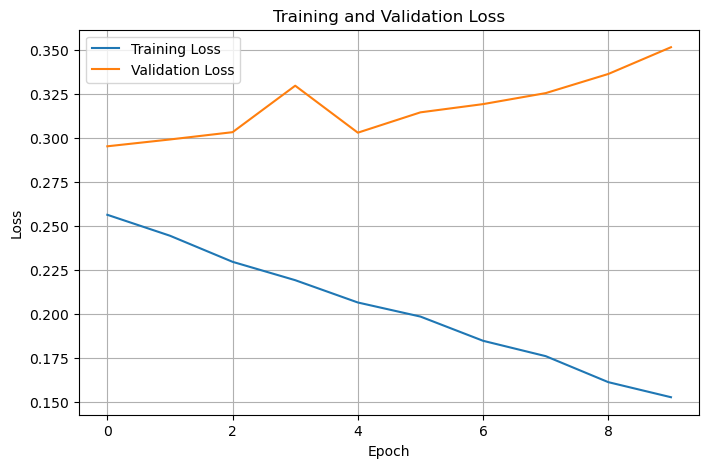

In [108]:
import matplotlib.pyplot as plt

# Train the model
start_train = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)
end_train = time.time()
train_duration = end_train - start_train
print(f"\n Training time: {train_duration:.2f} seconds")

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Evaluation

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    accuracy_score, f1_score, precision_score, recall_score
)

def evaluate_classification_model(model, train_ds, test_ds, class_names=None):
    def extract_labels(ds):
        y_true = []
        for _, label in ds.unbatch():
            y_true.append(int(label.numpy()))
        return np.array(y_true)

    def get_predictions(ds, label=""):
        start_predict = time.time()
        y_pred_probs = model.predict(ds, verbose=0).flatten()
        end_predict = time.time()

        predict_duration = end_predict - start_predict
        print(f"\nPrediction time on {label} set: {predict_duration:.2f} seconds")
        y_pred = (y_pred_probs > 0.5).astype(np.int64)
        return y_pred

    def evaluate(y_true, y_pred, label=""):
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)

        print(f"\n{label} SET METRICS")
        print(f"  Accuracy:       {acc:.4f}")
        print(f"  F1 Score:       {f1:.4f}")
        print(f"  Precision:      {prec:.4f}")
        print(f"  Recall:         {rec:.4f}")
        print(f"\nClassification Report ({label}):")
        print(classification_report(
            y_true, y_pred,
            target_names=class_names if class_names else None,
            zero_division=0
        ))

        return acc, f1, y_true, y_pred

    # Ground truth
    y_true_train = extract_labels(train_ds)
    y_true_test = extract_labels(test_ds)

    # Predictions
    y_pred_train = get_predictions(train_ds, "TRAIN" )
    y_pred_test = get_predictions(test_ds,  "TEST")

    # Evaluate
    train_acc, train_f1, y_train, y_train_pred = evaluate(y_true_train, y_pred_train, "TRAIN")
    test_acc, test_f1, y_test, y_test_pred = evaluate(y_true_test, y_pred_test, "TEST")

    # Plot confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ConfusionMatrixDisplay.from_predictions(
        y_train, y_train_pred,
        normalize='true', ax=ax1, display_labels=class_names
    )
    ax1.set_title(f'Train Confusion Matrix\nAcc: {train_acc:.2f}, F1: {train_f1:.2f}')
    ax1.tick_params(axis='x', rotation=45)

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_test_pred,
        normalize='true', ax=ax2, display_labels=class_names
    )
    ax2.set_title(f'Test Confusion Matrix\nAcc: {test_acc:.2f}, F1: {test_f1:.2f}')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()



Prediction time on TRAIN set: 52.40 seconds

Prediction time on TEST set: 12.16 seconds

TRAIN SET METRICS
  Accuracy:       0.9425
  F1 Score:       0.9397
  Precision:      0.9386
  Recall:         0.9408

Classification Report (TRAIN):
              precision    recall  f1-score   support

      Benign       0.95      0.94      0.94      5087
   Malignant       0.94      0.94      0.94      4628

    accuracy                           0.94      9715
   macro avg       0.94      0.94      0.94      9715
weighted avg       0.94      0.94      0.94      9715


TEST SET METRICS
  Accuracy:       0.8805
  F1 Score:       0.8757
  Precision:      0.8615
  Recall:         0.8904

Classification Report (TEST):
              precision    recall  f1-score   support

      Benign       0.90      0.87      0.88      1098
   Malignant       0.86      0.89      0.88       985

    accuracy                           0.88      2083
   macro avg       0.88      0.88      0.88      2083
weighted avg

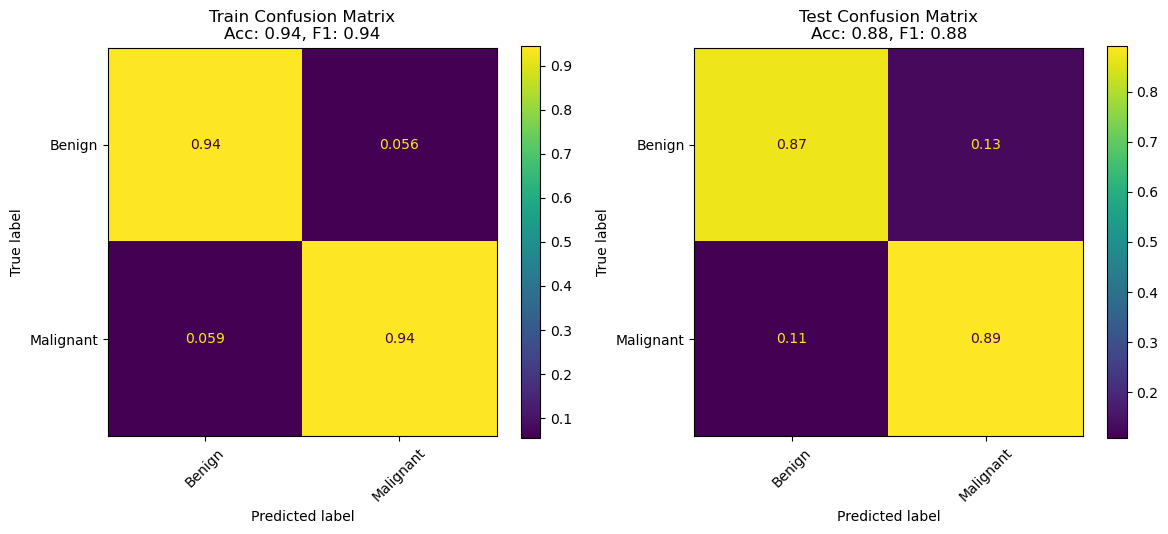

In [123]:
evaluate_classification_model(model, train_ds, test_ds, class_names=['Benign', 'Malignant'])

In [129]:
model.save_weights("fine_tuned_final.weights.h5")

### 2. Partially fine-tuned base model (last 30 layers unfrozen)

Epoch 1/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 93s 148ms/step - accuracy: 0.7542 - loss: 1.2247 - val_accuracy: 0.8496 - val_loss: 0.6041
Epoch 2/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 89s 146ms/step - accuracy: 0.8563 - loss: 0.3947 - val_accuracy: 0.8611 - val_loss: 0.4549
Epoch 3/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 90s 148ms/step - accuracy: 0.9014 - loss: 0.2504 - val_accuracy: 0.8693 - val_loss: 0.3964
Epoch 4/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 90s 148ms/step - accuracy: 0.9178 - loss: 0.2014 - val_accuracy: 0.8731 - val_loss: 0.3688
Epoch 5/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 89s 147ms/step - accuracy: 0.9369 - loss: 0.1517 - val_accuracy: 0.8751 - val_loss: 0.3557
Epoch 6/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 89s 147ms/step - accuracy: 0.9574 - loss: 0.1113 - val_accuracy: 0.8746 - val_loss: 0.3651
Epoch 7/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 88s 145ms/step - accuracy: 0.9692 - loss: 0.0830 - val_accuracy: 0.8779 - val_loss: 0.3674
Epoch 8/10
608/608 ━━━━━━━━━━━━━━━━━━━━ 88s 146ms/step - accuracy: 0.9838 - loss: 0

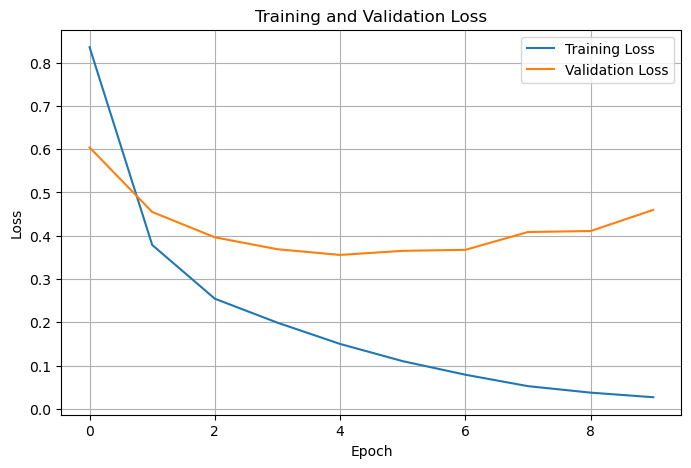

In [131]:
# Unfreeze from a specific layer
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all except last 30
    layer.trainable = False

# Recompile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), #smaller learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
start_train = time.time()
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)
end_train = time.time()
train_duration = end_train - start_train
print(f"\n Training time: {train_duration:.2f} seconds")

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Evaluation

2025-05-28 16:27:01.920955: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Prediction time on TRAIN set: 53.78 seconds

Prediction time on TEST set: 12.14 seconds

TRAIN SET METRICS
  Accuracy:       0.9686
  F1 Score:       0.9671
  Precision:      0.9653
  Recall:         0.9689

Classification Report (TRAIN):
              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97      5087
   Malignant       0.97      0.97      0.97      4628

    accuracy                           0.97      9715
   macro avg       0.97      0.97      0.97      9715
weighted avg       0.97      0.97      0.97      9715


TEST SET METRICS
  Accuracy:       0.8891
  F1 Score:       0.8848
  Precision:      0.8696
  Recall:         0.9005

Classification Report (TEST):
              precision    recall  f1-score   support

      Benign       0.91      0.88      0.89      1098
   Malignant       0.87      0.90      0.88       985

    accuracy                           0.89      2083
   macro avg       0.89      0.89      0.89      2083
weighted avg

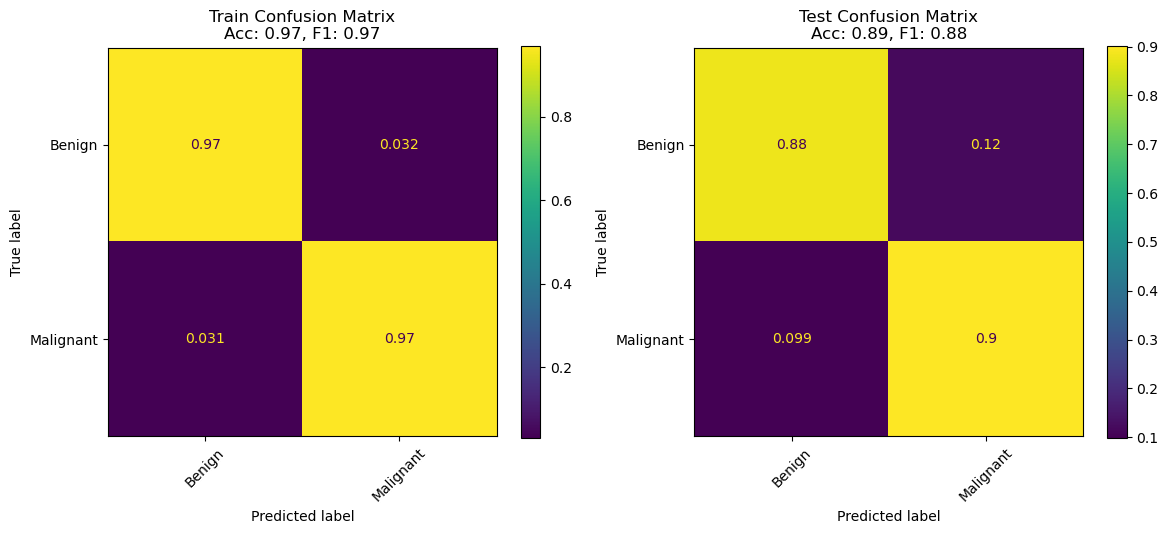

In [133]:
evaluate_classification_model(model, train_ds, test_ds, class_names=['Benign', 'Malignant'])

In [135]:
model.save_weights("unfreezed_final.weights.h5")

### 3. Fine-tuned base with data augmentation

In [137]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

#### Augmentation

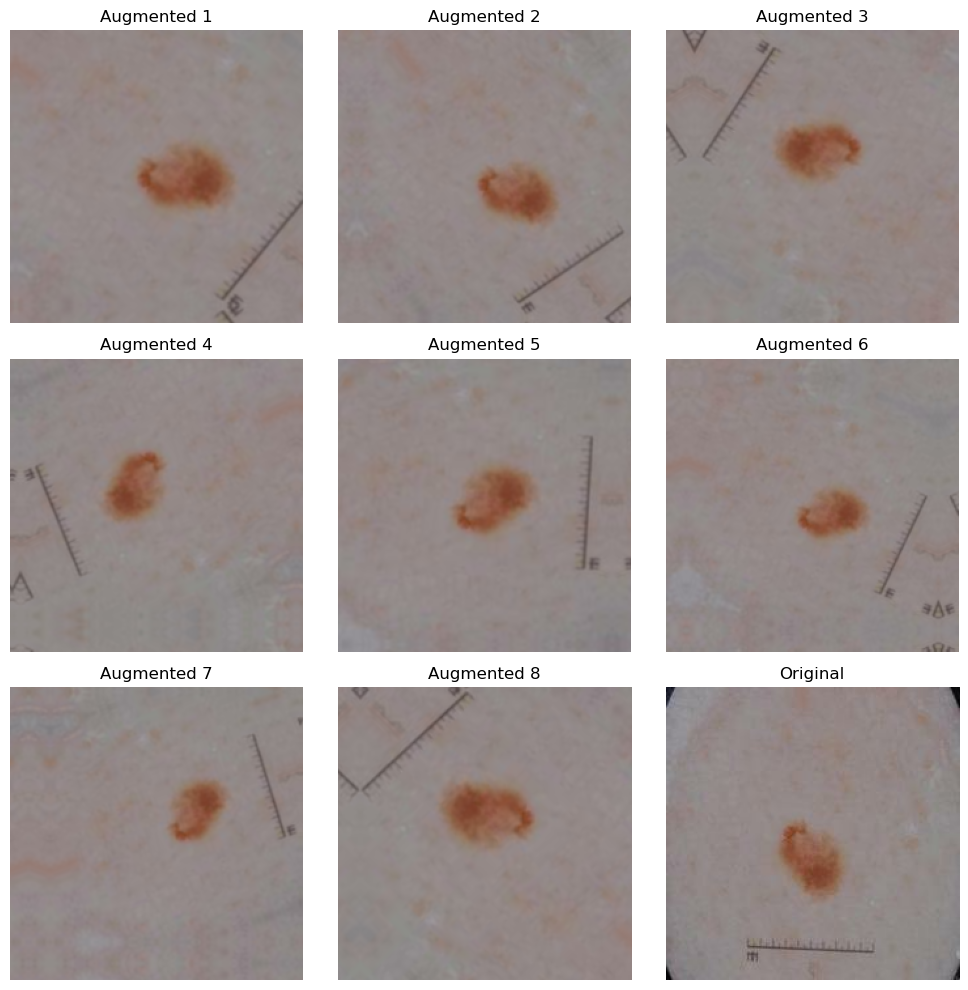

In [167]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Define augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), # Randomly flips images horizontally and vertically
    layers.RandomRotation(0.5), # Rotates images randomly by up to 50% of 360°
    layers.RandomZoom(0.2), #	Zooms in or out randomly by up to 20%
    layers.RandomTranslation(0.1, 0.1), #Shifts image horizontally and vertically by 10%
])

# Get a sample image from train_ds
for images, labels in train_ds.take(1):
    sample_image = images[0]
    break

# Plot 8 augmented + 1 original
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    if i < 8:
        # Force training=True so augmentations apply
        augmented_img = data_augmentation(tf.expand_dims(sample_image, 0), training=True)[0]
        img = tf.clip_by_value(augmented_img, 0.0, 1.0)
        title = f"Augmented {i + 1}"
    else:
        img = sample_image
        title = "Original"

    plt.imshow(img.numpy())
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()


#### Adding augmentation layer

In [169]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load pretrained MobileNetV2 base
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze all layers

# Add custom classification head
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])


In [171]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (1, 224, 224, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (1, 7, 7, 1280)        │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (1, 1280)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 128)               │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 94s 149ms/step - accuracy: 0.6815 - loss: 0.5764 - val_accuracy: 0.7876 - val_loss: 0.4327
Epoch 2/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 90s 147ms/step - accuracy: 0.8049 - loss: 0.4169 - val_accuracy: 0.8275 - val_loss: 0.3702
Epoch 3/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 94s 155ms/step - accuracy: 0.8233 - loss: 0.3881 - val_accuracy: 0.8496 - val_loss: 0.3401
Epoch 4/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 94s 155ms/step - accuracy: 0.8335 - loss: 0.3733 - val_accuracy: 0.8525 - val_loss: 0.3298
Epoch 5/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 95s 156ms/step - accuracy: 0.8501 - loss: 0.3554 - val_accuracy: 0.8544 - val_loss: 0.3298
Epoch 6/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 96s 158ms/step - accuracy: 0.8541 - loss: 0.3390 - val_accuracy: 0.8467 - val_loss: 0.3319
Epoch 7/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 97s 160ms/step - accuracy: 0.8540 - loss: 0.3341 - val_accuracy: 0.8578 - val_loss: 0.3188
Epoch 8/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 95s 157ms/step - accuracy: 0.8567 - loss: 0

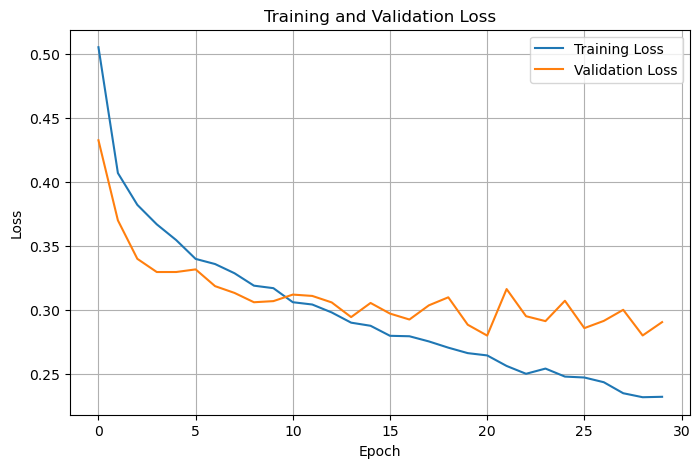

In [173]:
import matplotlib.pyplot as plt
import time

# Unfreeze from a specific layer
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all except last 30
    layer.trainable = False

# Recompile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), #smaller learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

batch_size=64
# Fine-tune
start_train = time.time()
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

end_train = time.time()
train_duration = end_train - start_train
print(f"\n Training time: {train_duration:.2f} seconds")

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Evaluation


Prediction time on TRAIN set: 50.10 seconds

Prediction time on TEST set: 11.14 seconds

TRAIN SET METRICS
  Accuracy:       0.8938
  F1 Score:       0.8828
  Precision:      0.9301
  Recall:         0.8401

Classification Report (TRAIN):
              precision    recall  f1-score   support

      Benign       0.87      0.94      0.90      5087
   Malignant       0.93      0.84      0.88      4628

    accuracy                           0.89      9715
   macro avg       0.90      0.89      0.89      9715
weighted avg       0.90      0.89      0.89      9715


TEST SET METRICS
  Accuracy:       0.8805
  F1 Score:       0.8680
  Precision:      0.9080
  Recall:         0.8315

Classification Report (TEST):
              precision    recall  f1-score   support

      Benign       0.86      0.92      0.89      1098
   Malignant       0.91      0.83      0.87       985

    accuracy                           0.88      2083
   macro avg       0.88      0.88      0.88      2083
weighted avg

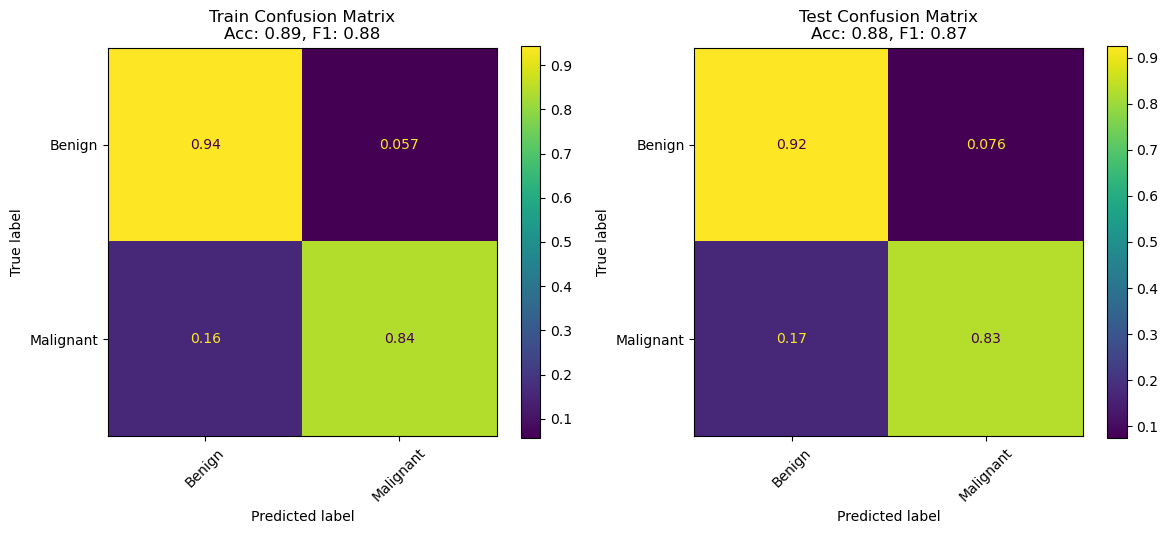

In [182]:
evaluate_classification_model(model, train_ds, test_ds, class_names=['Benign', 'Malignant'])

In [184]:
model.save_weights("unfreezed_augmented_final.weights.h5")

## Conclusion  

We evaluated three different transfer learning strategies with MobileNetV2 for melanoma classification. The results are summarized below:  

| Configuration                                | Epochs | Accuracy | F1-score | Recall (Malignant) |
|---------------------------------------------|--------|----------|----------|---------------------|
| Frozen MobileNetV2 base + custom head        | 10     | **88.05%** | 0.8757   | 0.89                |
| Partially fine-tuned MobileNetV2 (last 30 layers unfrozen) | 10     | **88.91%** | 0.8848   | **0.90**            |
| Fine-tuned MobileNetV2 with data augmentation | 30     | **88.05%** | 0.8680   | 0.83                |

### Analysis  

- The **frozen base model with only a custom classification head** produced a strong baseline, transferring general ImageNet features but showing limited adaptation to the unique visual characteristics of melanoma lesions.  
- The **partially fine-tuned model (last 30 layers unfrozen)** provided the best results. Allowing deeper layers to adapt to lesion-specific features improved generalization and delivered the highest recall, which is especially critical for medical applications where false negatives must be minimized.  
- The **fine-tuned model with additional data augmentation**, even when trained for longer, demonstrated steady learning but did not surpass the selectively fine-tuned configuration. The increased complexity and regularization from augmentation likely slowed convergence and reduced sensitivity to malignant cases.  

### Final Conclusion  
Among the three strategies, the **partially fine-tuned MobileNetV2** demonstrated the most effective trade-off between accuracy, F1-score, and recall. This highlights the importance of selective fine-tuning in transfer learning, as it allows the model to adapt deeper layers to domain-specific features without over-regularization. For melanoma detection tasks, where minimizing false negatives is critical, this configuration provides the most reliable results.  


## Contributions  
This project contributes by:  
- Applying and comparing three distinct MobileNetV2 configurations on a curated melanoma dataset.  
- Emphasizing **recall** as a critical metric for clinical tasks.  
- Analyzing the impact of **layer unfreezing, data augmentation, and training duration**.  
- Providing practical insights for deploying lightweight CNNs in sensitive domains like dermatology.  